In [7]:
from FastFitClassifier import FastFitClassifier
import pandas as pd
from tqdm.auto import tqdm

tqdm.pandas()

In [8]:
DEV = True
model_path = "./models/relevance/avsolatorio/GIST-small-Embedding-v0"



if not DEV:
    model_path = './models/relevance/avsolatorio/GIST-Embedding-v0'

model_path = './models/relevance/dev/jinaai/jina-embeddings-v2-small-en'

In [9]:
def import_labelled_data(path="data/level-0.5/data.json"):
    data = pd.read_json(path, encoding="latin-1")
    return data



print("Loading data...")

test_dataset = import_labelled_data(path="../../../data/level-0.5/irrelevant.json", )

print("Data loaded.")

if DEV:
    test_dataset = test_dataset.sample(5000)

test_dataset = test_dataset.sample(frac=1).reset_index(drop=True)


test_dataset.info()

Loading data...
Data loaded.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   url           5000 non-null   object
 1   text          5000 non-null   object
 2   relevance     5000 non-null   object
 3   multiclasses  5000 non-null   object
dtypes: object(4)
memory usage: 156.4+ KB


In [10]:
test_dataset.head()

,url,text,relevance,multiclasses
0,https://www.deped.gov.ph/wp-content/uploads/CO...,of Philippines Republic DEPARTMENT OF EDUCATIO...,irrelevant,[]
1,https://repositorio.usmp.edu.pe/bitstream/hand...,"FACULTAD DE CIENCIAS DE LA COMUNICACIÓN, TURIS...",irrelevant,[]
2,https://www.daytonsuperior.com/docs/default-so...,Page 1/9 Safety Data Sheet acc. to OSHA HCS Pr...,irrelevant,[]
3,https://perso.lpsm.paris/~aguyader/files/teach...,Université Rennes 2 Licence MASS 2 Année 2013/...,irrelevant,[]
4,http://diassere.org.pe/wp-content/uploads/2019...,Miguel Ángel Ramos Padilla es profesor de la F...,irrelevant,[]


In [11]:
import torch
torch.cuda.empty_cache()

In [12]:
classifier = FastFitClassifier(
    model_path=model_path,
    text_overlap_proportion=0.2,
    device='cuda:0',
    max_length=4096
)

Loading model from ./models/relevance/dev/jinaai/jina-embeddings-v2-small-en ...
Model loaded.
Tokenizer loaded with max_length: 2147483648


The model 'FastFit' is not supported for text-classification. Supported models are ['AlbertForSequenceClassification', 'BartForSequenceClassification', 'BertForSequenceClassification', 'BigBirdForSequenceClassification', 'BigBirdPegasusForSequenceClassification', 'BioGptForSequenceClassification', 'BloomForSequenceClassification', 'CamembertForSequenceClassification', 'CanineForSequenceClassification', 'LlamaForSequenceClassification', 'ConvBertForSequenceClassification', 'CTRLForSequenceClassification', 'Data2VecTextForSequenceClassification', 'DebertaForSequenceClassification', 'DebertaV2ForSequenceClassification', 'DistilBertForSequenceClassification', 'ElectraForSequenceClassification', 'ErnieForSequenceClassification', 'ErnieMForSequenceClassification', 'EsmForSequenceClassification', 'FalconForSequenceClassification', 'FlaubertForSequenceClassification', 'FNetForSequenceClassification', 'FunnelForSequenceClassification', 'GemmaForSequenceClassification', 'Gemma2ForSequenceClassif


Classifier pipeline built.


#### Profiling Section

In [13]:
!python -m pip install line_profiler
%load_ext line_profiler

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [14]:
from transformers.pipelines.pt_utils import KeyDataset
from datasets import Dataset
print("Chunking data...", end="\r")
from chunking import chunk_dataset_and_explode

data = test_dataset.sample(100)

max_len=4096

chunked_data = chunk_dataset_and_explode(
    data, max_len=max_len, overlap=int(max_len * 0.2)
)

# get dict of chunk_ids to counts of that id so we can track when we've finished all chunks for a file
chunk_id_counts = chunked_data["chunk_id"].value_counts().to_dict()

print("Data chunked.")

chunked_dataset = Dataset.from_pandas(chunked_data)

print("Predicting...", end="\r")

%lprun -u 1e-3 -f FastFitClassifier.predict_chunks classifier.predict_chunks(KeyDataset(chunked_dataset,'text'),chunk_id_counts, chunked_data['chunk_id'],batch_size=16)

  0%|          | 0/100 [00:00<?, ?it/s]

Data chunked.


Files	:   0%|          | 0/100 [00:00<?, ?it/s]

Chunks	:   0%|          | 0/3368 [00:00<?, ?it/s]

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Calculated predictions.


Timer unit: 0.001 s

Total time: 34.2189 s
File: /workspace/GreyLit/GreyLiteratureClassifier/src/FastFit/level-1/FastFitClassifier.py
Function: predict_chunks at line 52

Line #      Hits         Time  Per Hit   % Time  Line Contents
    52                                               def predict_chunks(self, chunked_text, chunk_id_counts,chunk_ids, batch_size=64):
    53         1          0.0      0.0      0.0          predictions = []
    54         1          0.0      0.0      0.0          scores = []
    55                                           
    56         1          0.0      0.0      0.0          i = 0
    57                                           
    58         1          0.1      0.1      0.0          print("Predicting from chunks...", end="\r")
    59                                           
    60         2         29.8     14.9      0.1          with tqdm(total=len(chunk_id_counts),desc='Files\t') as files_pbar:
    61         2         33.2     16.6      0.1 

##### End Profiling

  0%|          | 0/5000 [00:00<?, ?it/s]

Data chunked.
Converting to Dataset format...


Files	:   0%|          | 0/5000 [00:00<?, ?it/s]

Chunks	:   0%|          | 0/5000 [00:00<?, ?it/s]

Calculated predictions.
Evaluating model...

-----------------------------------------------------



/workspace/GreyLit/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/workspace/GreyLit/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/workspace/GreyLit/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report: 
              precision    recall  f1-score   support

  irrelevant       1.00      0.97      0.98      5000
    relevant       0.00      0.00      0.00         0

    accuracy                           0.97      5000
   macro avg       0.50      0.48      0.49      5000
weighted avg       1.00      0.97      0.98      5000

-----------------------------------------------------
Accuracy: 0.9658
Precision: 0.5
Specificity: 0.9658


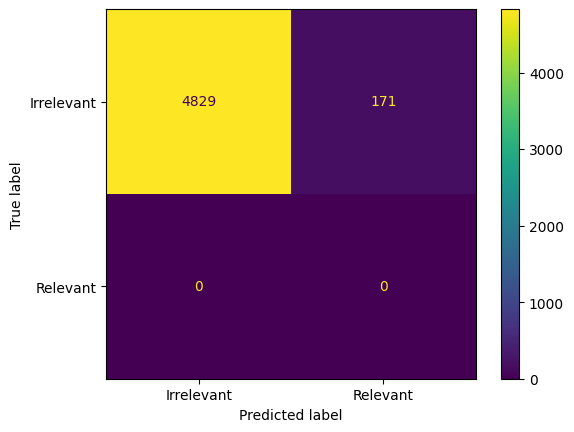

In [15]:

#! on fastfit/modeling.py, line 838, inserting **kwargs
#! it's easier than getting the tokenizer to stop outputting
#! extra info like token_type_ids

predicted_data = classifier.evaluate(
    test_dataset,
    metrics=[
        "accuracy",
        "precision",
        "classification-report",
        "specificity",
        "confusion-matrix-mpl",
    ],
    aggregate="majority",
    batch_size=16,
)

In [16]:
potential = predicted_data[predicted_data["predictions"] == "relevant"]
potential = potential.sort_values(by="score-lv1", ascending=False)


In [17]:
potential = potential[potential['text'].apply(lambda x: x!='No summary for this intervention.')]
potential = potential[potential['score-lv1'].apply(lambda x: x>=0.95)].reset_index(drop=True)

In [18]:
# get max min range of score
max_score = potential['score-lv1'].max()
min_score = potential['score-lv1'].min()
print(f"Max score: {max_score}")
print(f"Min score: {min_score}")



Max score: 1.0
Min score: 0.9999731779098511


In [19]:
with pd.option_context('display.max_colwidth', 400):
    display(potential.head(10))

,url,text,relevance,multiclasses,predictions,score-lv1
0,https://yearofthesalmon.org/wp-content/uploads/2022/12/11-Status-and-Trend-Masahide-Kaeriyama.pdf,"International Year of the Salmon Synthesis Symposium 4-6 October 2022 / Westin Bayshore, Vancouver, Canada Status and trend of production of Japanese chum salmon under the warming climate Masahide Kaeriyama Arctic Research Center, Hokkaido University salmon@arc.hokucai.ac.jp l Objects • This presentation reviews the evidence for warming climate impacts on Pacific salmon: (1) Temporal changes i...",irrelevant,[],relevant,1.0
1,https://digitalarchive.worldfishcenter.org/bitstream/handle/20.500.12348/2068/WF_390.pdf?sequence=1&isAllowed=y,Use of Genetically Improved and Alien Species for Aquaculture and Conservation of Aquatic Biodiversity in Africa Edited by Modadugu V. Gupta Devin M. Bartley Belen O. Acosta CHAPTER | Topic i Use of Genetically Improved and Alien Species for Aquaculture and Conservation of Aquatic Biodiversity in Africa Edited by Modadugu V. Gupta Devin M. Bartley Belen O. Acosta 2004 Published by WorldFish Ce...,irrelevant,[],relevant,1.0
2,http://yoderlab.org/cms/wp-content/uploads/2014/04/PNAS-2016-Federman-1523825113.pdf,"Implications of lemuriform extinctions for the Malagasy flora a,1 b c a d,e f Sarah Federman , Alex Dornburg , Douglas C. Daly , Alexander Downie , George H. Perry , Anne D. Yoder , g g a h,i,j Eric J. Sargis , Alison F. Richard , Michael J. Donoghue , and Andrea L. Baden a b Department of Ecology and Evolutionary Biology, Yale University, New Haven, CT 06520; North Carolina Museum of Natural ...",irrelevant,[],relevant,1.0
3,http://assets.worldwildlife.org/publications/817/files/original/Living_Blue_Planet_Report_2015_Final_LR.pdf,"REPORT INT 2015 Living Blue Planet Report Species, habitats and human well-being WWF WWF is one of the world’s largest and most experienced independent conservation organizations, with over 5 million supporters and a global network active in more than 100 countries. WWF’s mission is to stop the degradation of the planet’s natural environment and to build a future in which humans live in harmon...",irrelevant,[],relevant,1.0
4,https://yearofthesalmon.org/wp-content/uploads/2022/12/14-Managing-Salmon-Facilitator.pdf,"Managing Salmon Fisheries in a Rapidly Changing Salmosphere: The Future of Management Emerging Trends/Issues in Salmon Management to focus on through to 2030 Trends Regarding Challenges for Salmon: Growing uncertainty with respect to: • Climate change – influences all phases of life cycle including marine food production & migration patterns - influencing growth, survival, vulnerability to fis...",irrelevant,[],relevant,1.0
5,https://digitalarchive.worldfishcenter.org/bitstream/handle/20.500.12348/2992/Pub%20SR76%2022.pdf?sequence=1&isAllowed=y,"source Ecology of the Coral Reef System Rodolfo B. Reyes, Jr. Kathleen N. Kesner Association of Southeast Asian NationNnited States Coastal Resources Management Project International Center for Living Aquatic Resources Management Fisheries Stock Assessment-CollaborativeR esearch Support Program University of Rhode Island University of the Philippines Marine Science Institute Resource Ecology o...",irrelevant,[],relevant,1.0
6,https://zenodo.org/records/2491937/files/article.pdf,"Downloaded from http://jgslegacy.lyellcollection.org/ at New York University on April 27, 2015 Vol. 66.] MEGALOSA URUS BRADLEYI, 111 5. On a S~:w.i, of MEa,~LO~,~URVS fi'om the G a~Av OoT,I~ of MINCHINHA~fPTON (GLOUCESSERSHIRE). By AR~HVa SmTI~ WOODWARD, LL.D. , F.R.S. , Sec.G.S. (Read January 26th, 1910.) [PL/kTE XIII.] ALTtfOUGtt the carnivorous Dinosaur Meqalosa,rus was first dis- covered i...",irrelevant,[],relevant,1.0
7,http://youthla.org/wp-content/uploads/2018/05/restoration.pdf,"Ecological Engineering 71 (2014) 584–597 Contents lists available at ScienceDirect Ecological Engineering jo u r n a l h o m e p a g e : w w w . e l s e v i e r . c o m / l o c a t e / e c o l e n g

In [20]:

if DEV:
    from os import makedirs, path
    if not path.exists("../../../data/level-1.5/potential/dev"):
        makedirs("../../../data/level-1.5/potential/dev")
    potential.to_json("../../../data/level-1.5/potential/dev/data.json", orient="records", indent=4)
else:
    potential.to_json("../../../data/level-1.5/potential/data.json", orient="records", indent=4)